--- Data Summary ---
count    345588.000000
mean         30.803877
std           5.784489
min          25.760000
25%          26.990000
50%          28.350000
75%          32.430000
max          60.910000
Name: gage_height, dtype: float64

--- Missing Values ---
agency_cd             0
site_no               0
datetime              0
tz_cd                 0
gage_height           0
qualification_code    0
dtype: int64


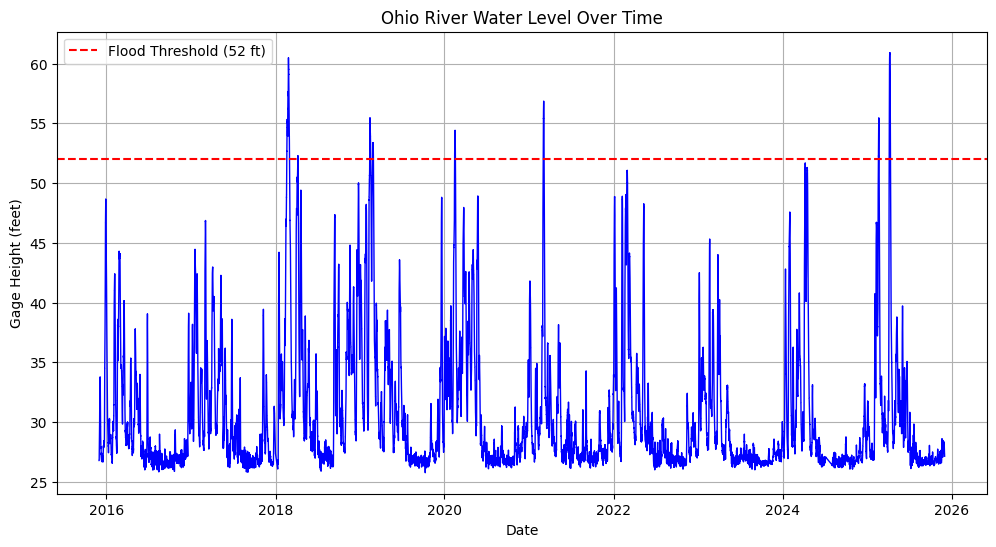

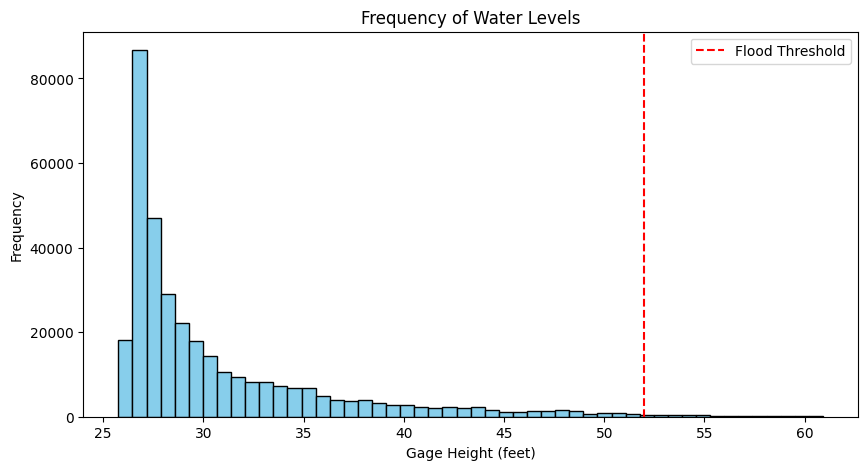

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data (using the column names we discussed)
file_path = 'nwis.waterservices.usgs.gov.txt'
column_names = ['agency_cd', 'site_no', 'datetime', 'tz_cd', 'gage_height', 'qualification_code']
df = pd.read_csv(file_path, sep='\t', names=column_names, comment='#')

# 2. Basic Cleaning
# Convert gage_height to numbers and datetime to dates
df['gage_height'] = pd.to_numeric(df['gage_height'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 3. Descriptive Statistics
print("--- Data Summary ---")
print(df['gage_height'].describe())

# 4. Check for Missing Values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# 5. Visualization: Plot the water level over time
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['gage_height'], color='blue', linewidth=1)
plt.axhline(y=52, color='red', linestyle='--', label='Flood Threshold (52 ft)')
plt.title('Ohio River Water Level Over Time')
plt.xlabel('Date')
plt.ylabel('Gage Height (feet)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Visualization: Distribution of Water Levels
plt.figure(figsize=(10, 5))
plt.hist(df['gage_height'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=52, color='red', linestyle='--', label='Flood Threshold')
plt.title('Frequency of Water Levels')
plt.xlabel('Gage Height (feet)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Phase 2: Feature Engineering & Modeling

In [4]:
# --- OPTIMIZED STEP 1 ---
# 1. Sort by time
df = df.sort_values('datetime')

# 2. Create a list of all lagged columns at once to avoid fragmentation
lookback_steps = 96
lags = [df['gage_height'].shift(i).rename(f'lag_{i}') for i in range(1, lookback_steps + 1)]

# 3. Join them all at once using concat
df_ml = pd.concat([df] + lags, axis=1)

# 4. Create the target (looking 24 hours / 96 steps ahead)
df_ml['target_height'] = df_ml['gage_height'].shift(-96)

# 5. Drop the empty rows (NaNs) and de-fragment the frame with .copy()
df_ml = df_ml.dropna().copy()

print(f"Data ready without warnings! New shape: {df_ml.shape}")

C:\Users\HP\AppData\Local\Temp\ipykernel_21024\2163222448.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ml['target_height'] = df_ml['gage_height'].shift(-96)


Data ready without warnings! New shape: (345396, 199)


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Define Features (the 96 lags) and Target (the future height)
X = df_ml.filter(like='lag_')
y = df_ml[['target_height']]

# 2. Split the data CHRONOLOGICALLY (important for time series!)
# We take the first 80% for training and last 20% for testing
split_idx = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 3. Scale the data to be between 0 and 1
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("Data Scaled and Split!")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Testing set size: {X_test_scaled.shape}")

Data Scaled and Split!
Training set size: (276316, 192)
Testing set size: (69080, 192)


Model

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Initialize the Neural Network
# We use two hidden layers (64 and 32 neurons)
model = MLPRegressor(hidden_layer_sizes=(64, 32),
                     activation='relu',
                     solver='adam',
                     max_iter=500,
                     random_state=42,
                     verbose=True)

# 2. Train the model
print("Training the model... this may take a minute.")
model.fit(X_train_scaled, y_train_scaled.ravel())

# 3. Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# 4. Unscale the predictions back to 'feet'
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

Training the model... this may take a minute.
Iteration 1, loss = 0.00092454
Iteration 2, loss = 0.00064170
Iteration 3, loss = 0.00062015
Iteration 4, loss = 0.00059460
Iteration 5, loss = 0.00057957
Iteration 6, loss = 0.00056172
Iteration 7, loss = 0.00055616
Iteration 8, loss = 0.00054169
Iteration 9, loss = 0.00053452
Iteration 10, loss = 0.00053498
Iteration 11, loss = 0.00051985
Iteration 12, loss = 0.00051627
Iteration 13, loss = 0.00051663
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


--- Results for 24-Hour Forecast ---
Average Error (RMSE): 1.01 feet
R2 Score: 0.9693


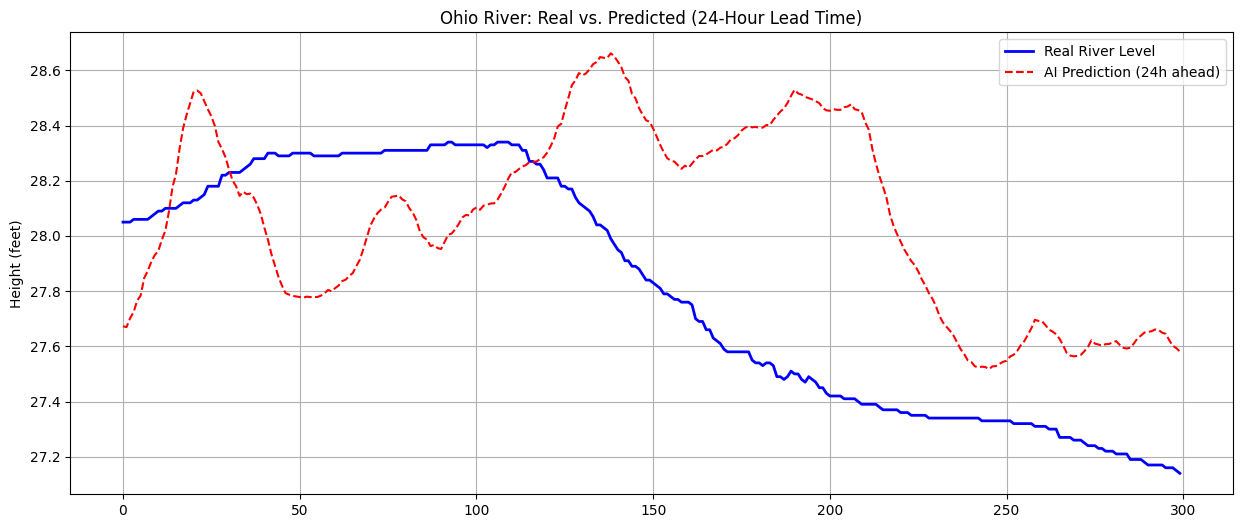

In [10]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# 2. Unscale the predictions back to 'feet'
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# 3. Calculate Accuracy Metrics (Updated for newer scikit-learn)
try:
    # Try the newest way first
    rmse = root_mean_squared_error(y_test_actual, y_pred)
except NameError:
    # If your version is older, use the traditional way
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

r2 = r2_score(y_test_actual, y_pred)

print(f"--- Results for 24-Hour Forecast ---")
print(f"Average Error (RMSE): {rmse:.2f} feet")
print(f"R2 Score: {r2:.4f}")

# 4. Plot the results
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[-300:], label='Real River Level', color='blue', linewidth=2)
plt.plot(y_pred[-300:], label='AI Prediction (24h ahead)', color='red', linestyle='--')
plt.title('Ohio River: Real vs. Predicted (24-Hour Lead Time)')
plt.ylabel('Height (feet)')
plt.legend()
plt.grid(True)
plt.show()

Dumb Model

In [12]:
# 1. The Persistence Forecast: Guessing that 'target' = 'current gage_height'
# We use the most recent lag (lag_1) from our X_test (unscaled) to represent "today's height"
y_persistence = X_test.iloc[:, 0].values

# 2. Calculate Persistence Error (Baseline)
from sklearn.metrics import root_mean_squared_error
persistence_rmse = root_mean_squared_error(y_test_actual, y_persistence)

print(f"--- Benchmark Comparison ---")
print(f"Persistence (Baseline) Error: {persistence_rmse:.2f} feet")
print(f"Your AI (MLP) Error:          {rmse:.2f} feet")

improvement = ((persistence_rmse - rmse) / persistence_rmse) * 100
print(f"\nYour AI is {improvement:.1f}% more accurate than just guessing the current value!")

--- Benchmark Comparison ---
Persistence (Baseline) Error: 1.57 feet
Your AI (MLP) Error:          1.01 feet

Your AI is 35.5% more accurate than just guessing the current value!


Feature Importance

Calculating importance for 192 features...


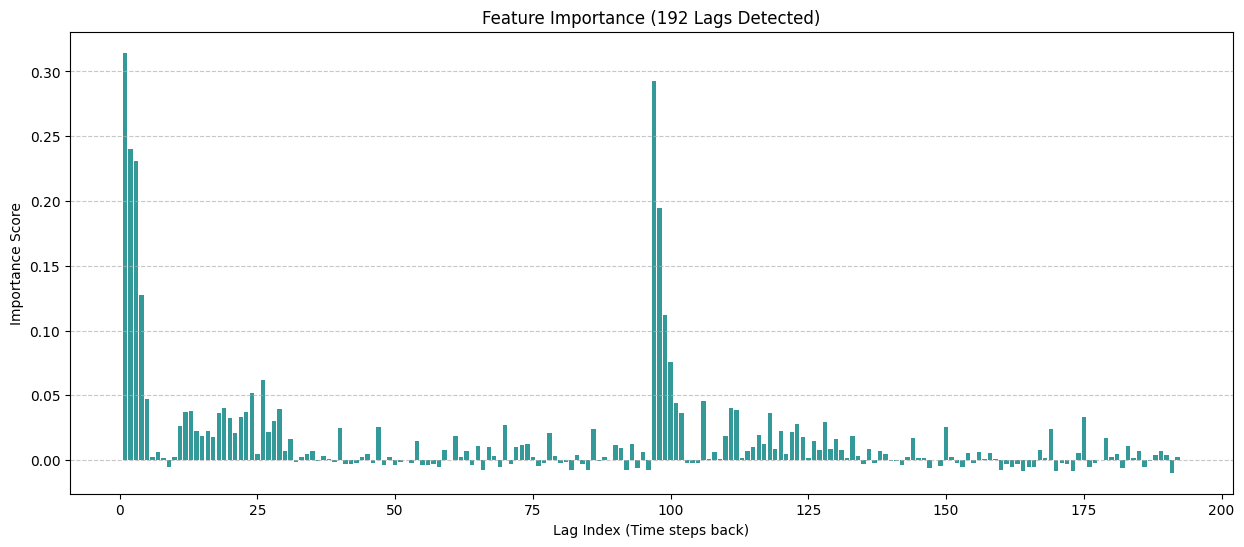

--- Top 5 Most Important Lags ---
Feature 1 (Approx 15 mins ago): Score 0.3145
Feature 97 (Approx 15 mins ago): Score 0.2926
Feature 2 (Approx 30 mins ago): Score 0.2405
Feature 3 (Approx 45 mins ago): Score 0.2306
Feature 98 (Approx 30 mins ago): Score 0.1945


In [14]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate Permutation Importance
# Using a subset of 5,000 samples to keep it fast
print(f"Calculating importance for {X_test_scaled.shape[1]} features...")
result = permutation_importance(
    model, X_test_scaled[:5000], y_test_scaled[:5000],
    n_repeats=5, random_state=42, n_jobs=-1
)

# 2. Get the importance values
importances = result.importances_mean
num_features = len(importances)

# 3. Plotting with dynamic length
plt.figure(figsize=(15, 6))
plt.bar(range(1, num_features + 1), importances, color='teal', alpha=0.8)

plt.title(f'Feature Importance ({num_features} Lags Detected)')
plt.xlabel('Lag Index (Time steps back)')
plt.ylabel('Importance Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Print the Top 5
top_indices = np.argsort(importances)[::-1][:5]
print("--- Top 5 Most Important Lags ---")
for idx in top_indices:
    # We use % 96 to find the 'actual' hour if lags were doubled
    actual_lag = (idx % 96) + 1
    print(f"Feature {idx+1} (Approx {actual_lag * 15} mins ago): Score {importances[idx]:.4f}")

In [15]:
# 1. Find the index of the highest water level in the test set
max_idx = np.argmax(y_test_actual)
max_actual = y_test_actual[max_idx][0]
max_predicted = y_pred[max_idx][0]
error_at_peak = abs(max_actual - max_predicted)

print(f"--- Peak Performance Check ---")
print(f"Highest Level in Test Set: {max_actual:.2f} feet")
print(f"AI Prediction for that time: {max_predicted:.2f} feet")
print(f"Absolute Error at Peak:     {error_at_peak:.2f} feet")

--- Peak Performance Check ---
Highest Level in Test Set: 60.91 feet
AI Prediction for that time: 59.16 feet
Absolute Error at Peak:     1.75 feet
